In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import re

In [2]:
def precision(tp, fp):
  return tp / (fp + tp)

def recall(tp, fn):
  return tp / (fn + tp)

def accuracy(tp, tn, fp, fn): 
  return (tp + tn)/ (tp + fn + tn + fp)

def f1score(tp, tn, fp, fn):
  return 2 * (precision(tp, fp) * recall(tp, fn))/(precision(tp, fp) + recall(tp, fn))

In [3]:
df = pd.read_csv("./Datasets/JoeBiden_stevewoz_katyperry_balanced_dataset.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,User,Tweet
0,4274,4274,JoeBiden,"We had a great night at the #DemDebate, but we..."
1,6510,6510,JoeBiden,VP Biden on Romney-Ryan: “They don’t tell you ...
2,8918,8918,katyperry,going through alligator alley on the way to St...
3,385,385,stevewoz,"A Dog’s Journey. Remembering the predecessor, ..."
4,6879,6879,JoeBiden,From taking care of their kids to accessing pr...


<AxesSubplot:xlabel='User'>

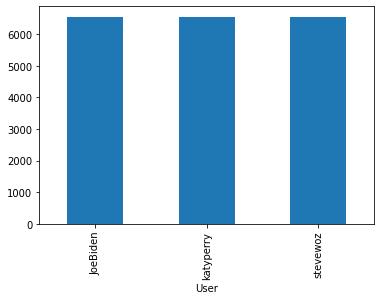

In [4]:
df.groupby(['User']).size().plot.bar()

In [5]:
authors = df['User'].unique()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {authors[i] : i for i in range(len(authors))}

batch_size = 8
labels

{'JoeBiden': 0, 'katyperry': 1, 'stevewoz': 2}

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['User']]
        self.texts = [tokenizer(re.sub(r"http\S+", '', text),  padding='max_length', max_length = 512, truncation=True,
                     return_tensors="pt") for text in df['Tweet']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [7]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, len(authors))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluate(model, test_data):

    predictions = []
    labels = []

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.to(device)

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              for i in range(len(test_label)):
                  labels.append(torch.Tensor.numpy(torch.Tensor.cpu(test_label))[i])

              for i in range(len(test_label)):
                  predictions.append(torch.Tensor.numpy(torch.Tensor.cpu(output.argmax(dim=1)))[i])
              
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    cm = confusion_matrix(labels, predictions)
    cr = classification_report(labels, predictions)

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
    return cm, cr

In [10]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.to(device)
            criterion = criterion.to(device)

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .5f} | Train Accuracy: {total_acc_train / len(train_data): .5f} | Val Loss: {total_loss_val / len(val_data): .5f} | Val Accuracy: {total_acc_val / len(val_data): .5f}')
            cm, cr = evaluate(model, df_test)
            print(cm)
            print(cr)
            torch.save(model.state_dict(), 'second_bert_model_epoch_' + str(epoch_num) + '.pt')

In [11]:
def sample(tweet):
    token = tokenizer(re.sub(r"http\S+", '', tweet),  padding='max_length', max_length = 512, truncation=True,
                     return_tensors="pt")
    
    mask = token['attention_mask'].to(device)
    token = token['input_ids'].to(device)

    output = model(token, mask).argmax(dim=1).item()
    print(model(token, mask))
    return output, list(labels.keys())[list(labels.values()).index(model(token, mask).argmax(dim=1).item())]

In [12]:
np.random.seed(112)
df_train, df_test, df_val = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

15722 1966 1965


In [ ]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

In [ ]:
tweet = "Hello World!"
sample(tweet)